In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

In [ ]:
# 현재 작업 디렉토리 확인
!pwd

/content


In [ ]:
# 작업 디렉토리 변경
%cd "./drive/MyDrive/Colab Notebooks/23.12.18딥러닝"

/content/drive/MyDrive/Colab Notebooks/23.12.18딥러닝


In [ ]:
!pwd

/content/drive/MyDrive/Colab Notebooks/23.12.18딥러닝


In [ ]:
# 현재 작업 폴더 내부 탐색
!ls

### 0. 실습 목표
- keras를 이용한 딥러닝 모델링 익숙지기
- 데이터 로딩 > 이미지 특징 추출 (전처리) > 학습 > 평가 코드로 진행해보기
- GPU 환경 활용해보기
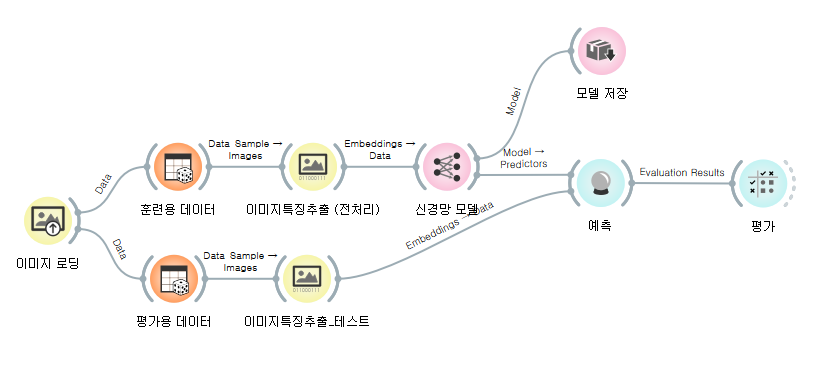

### 1. 데이터 로딩

##### 1. 압출 풀기

In [ ]:
# !unzip ./data/small.zip -d ./data/animal_sample/

In [ ]:
# 라이브러리 로딩
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm  # 진행율을 시각화 해주는 도구
from tensorflow.keras.utils import image_dataset_from_directory  # 폴더에서 이미지를 불러오는 도구
from sklearn.model_selection import train_test_split # 훈련/평가용 데이터 분리 함수
from tensorflow.keras.applications import InceptionV3 # 이미지 특징을 추출하는 도구
from tensorflow.keras.models import Sequential # 딥러닝 모델의 뼈대
from tensorflow.keras.layers import Dense # 뉴런의 묶음을 표현하는 클래스
from tensorflow.keras.callbacks import EarlyStopping # 조기학습 중단
from tensorflow.keras.callbacks import ModelCheckpoint # 모델자동저장
from tensorflow.keras.models import load_model # hdf5 포멧의 모델 파일을 로딩하는 함수
from sklearn.metrics import classification_report # 분류평가지표 확인 함수


### 2. 이미지

In [ ]:
total_data=image_dataset_from_directory(
    directory ="./data/animal_sample/", # 읽어들일 경로 지정
    labels="inferred", # 폴더명을 인식해서 정답으로 붙여준다.
    label_mode="categorical",# 다중분류 데이터 셋 형태로 인식 -> 정답 포멧도 다중분류용 포멧으로 설정
    color_mode="rgb", # 컬러 사진 설정
    image_size=(224,224) # 이미지 크기 리사이징

)

NameError: ignored

In [ ]:
X_data=[] # 문제가 들어갈 리스트
y_data=[] # 정답이 들어갈 리스트

In [ ]:
# 32개씩 (배치 사이즈) 데이터 읽기
# 배치 사이즈 : 효율적인 메모리 관리를 위해 데이터를 작은 크기로 나누어 관리하는 개념
for img, label in tqdm(total_data.as_numpy_iterator()):
  X_data.append(img)
  y_data.append(label)


157it [09:40,  3.69s/it]


In [ ]:
#리스트에 32개씩 담긴 데이터들을 하나의 numpy로 통합
X_numpy = np.concatenate(X_data)
y_numpy= np.concatenate(y_data)
X_numpy.shape,y_numpy.shape

((5000, 224, 224, 3), (5000, 10))

In [ ]:
# 읽어들인 numpy 데이터를 파일로 저장 (npz)
# 매번 데이터를 읽어들이면 시간이 걸리기 때문에 파일로 저장하여 로딩하는 형식
np.savez("./data/animal.npz",X=X_numpy,y=y_numpy)

In [ ]:
# npz 파일 읽기
npz_data=np.load("./data/animal.npz")
X_numpy=npz_data['X']
y_numpy=npz_data['y']
X_numpy.shape,y_numpy.shape


((5000, 224, 224, 3), (5000, 10))

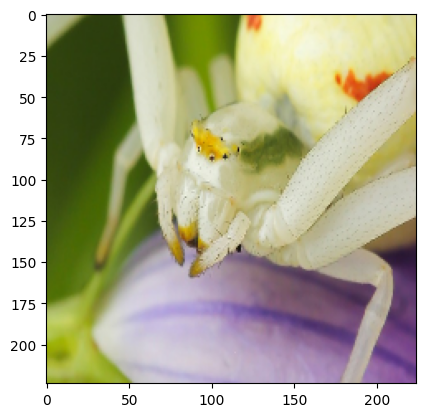

In [ ]:
# 데이터 확인
plt.imshow(X_numpy[1202].astype("int64"))

### 2. 훈련 / 평가 데이터 분리

In [ ]:
X_train, X_test, y_train,y_test= train_test_split(X_numpy,y_numpy, test_size=0.2,random_state=1219)

In [ ]:
X_train.shape,X_test.shape

((4000, 224, 224, 3), (1000, 224, 224, 3))

In [ ]:
y_train.shape,y_test.shape

((4000, 10), (1000, 10))

In [ ]:
# 불필요한 메모리 제거
del X_numpy
del y_numpy

### 3. 이미지 특징 추출 (전처리)도구 생성

In [ ]:
imageEmbedding=InceptionV3(
    include_top=False,
    weights="imagenet",
    input_shape=(224,224,3),# 이미지 특징을 추출할 데이터의 크기 (모양)
    pooling='avg'
)

87910968/87910968 [==============================] - 5s 0us/step


### 4. 모델 설계 및 학습
- 딥러닝 모델은 자유도가 높다. -> 사용자가 원라는 형태로 층층이 쌓아 만들 수 있다. 단, 비슷한 성능이라면 가벼운(용량이 적은) 모델이 유리하다.
- 모델 학습의 시간 낭비를 줄이기 위해 조기 학습 중단, 모델 자동 저장은 필수다.

In [ ]:
animal_model = Sequential() # 뼈대 생성
animal_model.add(imageEmbedding) # 이미지 특징 추출 도구 연결
animal_model.add(Dense(units=128, activation='relu')) # 원하는 만큼 뉴런 연결
animal_model.add(Dense(units=256, activation='relu'))
animal_model.add(Dense(units=179, activation='relu'))
animal_model.add(Dense(units=10, activation='softmax'))

In [ ]:
# 모델의 요약정보 확인
animal_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 179)               46003     
                                                                 
 dense_3 (Dense)             (None, 10)                1800      
                                                                 
Total params: 22145883 (84.48 MB)
Trainable params: 22111451 (84.35 MB)
Non-trainable params: 34432 (134.50 KB)
_________________________________________________________________


#### 2. 학습을 위한 셋팅
- 최적화 함수, 손실 함수, 평가방법 적용

In [ ]:
animal_model.compile(loss="categorical_crossentropy", # 모델의 잘못된 정도(오차)를 측정하는 도구
                     optimizer="adam", # 모델 최적화 도구 -> 경사하강법 알고리즘
                     metrics=['accuracy'] # 모델의 평가지표
                     )

### 3. 효과적인 학습을 위한 callback 함수 셋팅
- 조기학습 중단: 모델 학습시 일정 횟수 내에 성능이 개선되지 않으면 자동으로 학습을 중단하는 기능(학습시간 낭비 방지)
- 모델 자동 저장 : 모델이 최고 성능을 찍었을때 중간 자동 저장하는 기능 (과대적합방지)

In [ ]:
early=EarlyStopping(monitor="val_accuracy", # 모델의 성능을 판단하기 위해 모니터링할 척도
                    patience=5 # 성능 개선 여부를 지켜볼 epoch 횟수 (인내심 횟수)
                    )

In [ ]:
model_path="./animal_model/animal-{epoch:02d}-{val_accuracy:.2f}.hdf5" # 모델이 저장될 경로 파일 이름
mdckp=ModelCheckpoint(filepath=model_path, # 파일 경로 연결
                      save_best_only=True, # 모델의 성능이 최고점을 돌파할때만 저장
                      monitor="val_accuracy") # 모델의 성능을 판단하기 위해 모니터링 할 척도

### 4. 모델학습

In [ ]:
h = animal_model.fit(X_train,y_train,
                     validation_split=0.2, # 검증 데이터 비율 설정
                     epochs= 100, # 학습  반복 횟수 설정
                     callbacks=[early,mdckp], # 조기학습 중단, 모델 자동저장 적용
                     batch_size=16) # 한번에 RAM 메모리에 적재되는 데이터의 수

### 5. test 데이터 예측 및 모델 평가

In [ ]:
# best 모델로딩
best_animal_model = load_model("./animal_model/animal-08-0.70.hdf5")

In [ ]:
# best 모델에게 테스트 데이터 예측 시키기
pre=best_animal_model.predict(X_test)

32/32 [==============================] - 8s 134ms/step


In [ ]:
pre[0]

array([0.00241804, 0.00500122, 0.08195307, 0.01751786, 0.03728861,
       0.01473418, 0.81902945, 0.00486436, 0.00451544, 0.01267783],
      dtype=float32)

In [ ]:
# 분류는 항상 활률을 먼저 예측
# 클래스 번호를 보고싶으면 argmax를 이용
print(pre[0])
print(np.argmax(pre[0]))

[0.00241804 0.00500122 0.08195307 0.01751786 0.03728861 0.01473418
 0.81902945 0.00486436 0.00451544 0.01267783]
6


In [ ]:
print(total_data.class_names)

['butterfly', 'cat', 'chicken', 'cow', 'dog', 'elephant', 'horse', 'sheep', 'spider', 'squirrel']


In [ ]:
# 분류평가지표 확인
print(classification_report(y_test.argmax(axis=1), # 실제 정답
                           pre.argmax(axis=1) # 모델의 예측값
))

              precision    recall  f1-score   support

           0       0.66      0.48      0.56       106
           1       0.90      0.63      0.74       101
           2       0.65      0.91      0.76        96
           3       0.86      0.65      0.74       100
           4       0.78      0.42      0.55        92
           5       0.95      0.53      0.68       106
           6       0.87      0.61      0.72        96
           7       0.56      0.67      0.61        90
           8       0.50      0.92      0.65       103
           9       0.57      0.87      0.69       110

    accuracy                           0.67      1000
   macro avg       0.73      0.67      0.67      1000
weighted avg       0.73      0.67      0.67      1000



### 6. 모델 활용하기

In [ ]:
!pip install kaleido
!pip install fastapi==0.99.0
!pip install gradio==3.30.0

In [ ]:
import gradio as gr

# 예측 알고리즘을 적용한 사용자 정의 함수
def my_predict(input_data) :
  imput_img = input_data.reshape(1,224,224,3) # 1장의 이미지, 크기(224,224), 컬러사진
  pre = best_animal_model.predict(imput_img) # 매개변수로 들어온 이미지를 모델에게 예측시킴
  class_names = ["나비","고양이","닭","소","개","코끼리","말","양","거미","다람쥐"]
  return class_names[pre.argmax(axis=1)[0]] # 확률중에 제일 높은 클래스번호를 글자로 변경

demo = gr.Interface(my_predict, # 예측 함수 연결
                    inputs= gr.Image(shape=(224,224)), # 생성될 입력 인터페이스 설정
                    outputs= "text") # 생성될 출력 인터페이스 설정
# 앱 실행
demo.launch(share=True) # share 옵션 : 외부에서 접속 가능한 URL 생성(일시적)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://7282d96acdc2b730aa.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces
